## PURPOSE OF THE NOTEBOOK
The aim of this notebook is to obtain regional expression patterns, rather than single cell patterns. This is will be then, useful for (1) identifying regional expression programs and (2) compare the regional signatures with other regional signature,for instance, the ivy-gap or the GBmap modules

# Import all libraries & functions needed

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')
import squidpy as sq
import scanpy as sc
import os 
from scipy.stats import entropy
import seaborn as sns
from tqdm import tqdm
from random import sample
from numpy import dot
from numpy.linalg import norm

In [ ]:
def format_data_neighs_colapse(adata,sname,condit,neighs=10):
    adata.obsm["spatial"]=np.array([adata.obs.X,adata.obs.Y]).transpose().astype('float64')
    adata_copy_int=adata
    sq.gr.spatial_neighbors(adata_copy_int,n_neighs=neighs)
    result=np.zeros([adata.shape[0],adata.shape[1]])
    n=0
    tr=adata_copy_int.obsp['spatial_distances'].transpose()
    tr2=tr>0
    exp=adata_copy_int.to_df()
    from tqdm import tqdm
    #tdd=tr2.todense()
    for i in tqdm(range(0,adata_copy_int.to_df().shape[0])):
        result[i,:]=np.sum(exp[tr2[i,:].todense().transpose()],axis=0)
    adata1=sc.AnnData(result,obs=adata.obs,var=adata.var)
    return adata1
def cosinesim(a,b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return (cos_sim)

# Read objects

Load the data, obtained from STEP 1

In [5]:
general_path='/media/sergio/GBX/GBmap samples'
global_path=general_path+'ISS_samples/'

In [ ]:
adata=sc.read(general_path+'/ISS_global_analysis/all_samples_unprocessed.h5ad') #modify if possible

In this new version of the function, we search for neighbors, but return the aggregated expression of the neighbors and store it in expression

In [ ]:
anndata_list = []
level='level3'
for sample in adata.obs['sample'].unique():
    adata_copy_int = adata[adata.obs['sample']==sample]
    adataneigh2=format_data_neighs_colapse(adata_copy_int,level,sample,neighs=15)
    anndata_list.append(adataneigh2)
adata_regional=sc.concat(anndata_list)

100%|█████████████████████████████████████████████████████████████████████████▋| 263595/264721 [58:10<00:10, 103.89it/s]

# We first transform the data

In [ ]:
starting=adata.obs.shape[1]
adata_regional.raw=adata_regional
sc.pp.normalize_total(adata_regional)
sc.pp.log1p(adata_regional)
adata_regional.obsm["spatial"]=np.array([adata_regional.obs.X,adata_regional.obs.Y]).transpose().astype('float64')

# Now we can start applying signatures

In [14]:
module=pd.read_csv(general_path+r"/module_list_GBM.csv",sep=';')

In [15]:
module_present=['Cytotoxic', 'INF', 
       'Chemotaxis',
       'Aging Signals', 'Pro-inflammatory I', 'Tumor-supportive',
       'Anti-inflammatory', 'Pro-inflammatory II',
        'Immune Activ.', 'Angiogenic sprouting',
       'ECM remodeling/angiogenesis', 'GBMVerse - Stress Signals', 'GBMVerse Hypoxia',
       'GBMVerse - Cell Cycle Programs']

In [16]:
module_names=[]
for mod in module_present:
    try:
        sel=module[module['Module']==mod]
        sc.tl.score_genes(adata_regional,sel['Gene'],score_name='module_'+mod)
        module_names.append('module_'+mod)
    except:
        print('not possible')
adata_regional.obsm=adata.obsm

# this step plots every module on every sample, and it takes a while

In [45]:
starting=19#9

In [ ]:
import matplotlib
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100, frameon=False, vector_friendly=True, fontsize=7, figsize=(8,8), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100, frameon=True, vector_friendly=True, fontsize=14, figsize=(10,10), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
for md in adata_regional.obs.columns[starting:]:
    vvmax=np.percentile(adata_regional.obs.loc[:,md],99)
    vvmin=np.percentile(adata_regional.obs.loc[:,md],1)
    for s in adata_regional.obs['sample'].unique():
        adata_regional_sub=adata_regional[adata_regional.obs['sample']==s]
        sc.pl.spatial(adata_regional_sub,spot_size=60,color=md,vmin=vvmin,vmax=vvmax,cmap='coolwarm',show=False)
        plt.savefig(general_path+'/ISS_global_analysis/modules/expression_map_'+str(s)+'_'+md.replace('/','_')+'.pdf')
        #sc
        #plt.title(s)
        #plt.show()


In [48]:
modules=adata_regional.obs.loc[:,module_names]

In [49]:
express=modules
corr=pd.DataFrame(index=express.columns,columns=express.columns)
for i in tqdm(corr.index):
    #print(i)
    for c in corr.columns:
        corr.loc[i,c]=np.corrcoef(express.loc[:,i],express.loc[:,c])[0,1]

100%|███████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.34it/s]


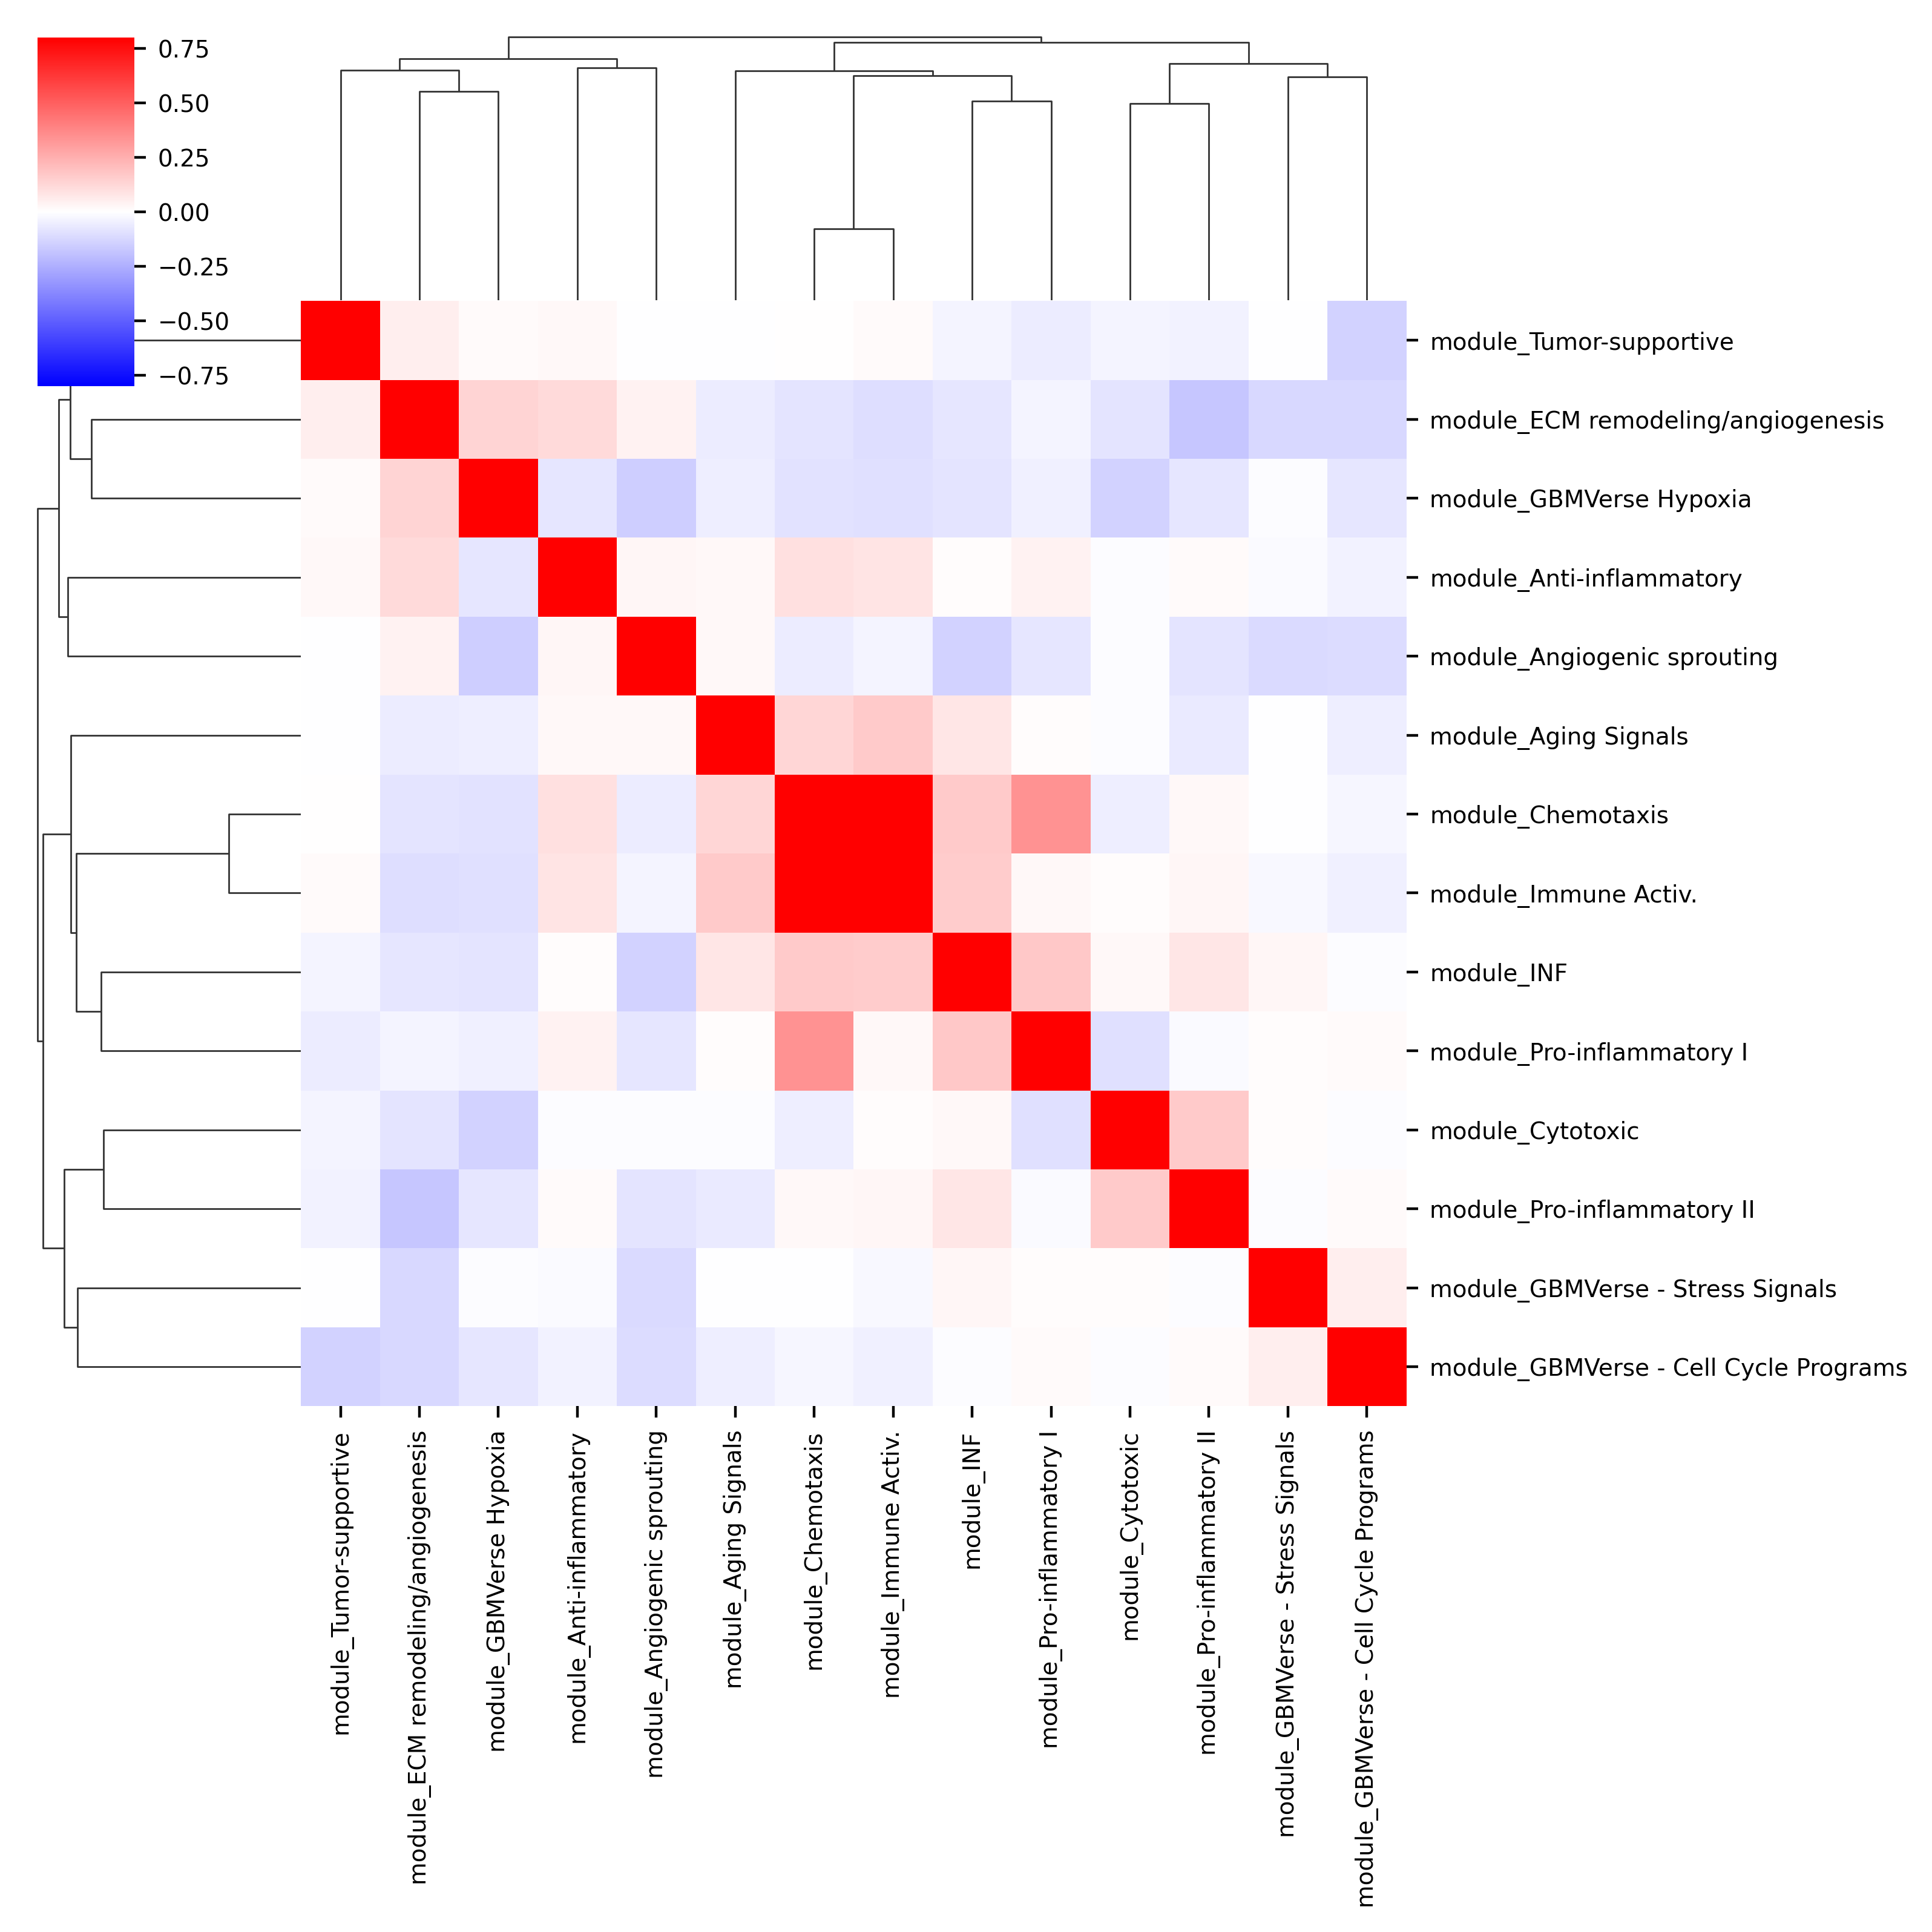

In [50]:
for i in corr.index:
    corr.loc[i,i]=0
sel=corr.index[np.max(abs(corr))>0.1]
corr2=corr.loc[sel,sel]
for i in corr2.index:
    corr2.loc[i,i]=1
    
import matplotlib
sc.set_figure_params(scanpy=True, dpi=200, dpi_save=200, frameon=False, vector_friendly=True, fontsize=7, figsize=(8,8), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.clustermap(corr2.astype(float),vmax=0.8,figsize=(8,8),vmin=-0.8,cmap='bwr')
plt.savefig(general_path+'/ISS_global_analysis/modules/correlation_between_modules_all_samples.pdf')

In [51]:
# we now check similarity between modules in terms of shared genes, since this could bias the analysis.

In [52]:
module_similarity=pd.DataFrame(index=module_names,columns=module_names)

In [53]:
for mod in module_present:
    sel=module[module['Module']==mod]
    list1=sel['Gene'][sel['Gene'].isin(adata_regional.var.index)]
    for mod2 in module_present:
        sel2=module[module['Module']==mod2]
        list2=sel2['Gene'][sel2['Gene'].isin(adata_regional.var.index)]
        module_similarity.loc['module_'+mod,'module_'+mod2]=int(len(list1[list1.isin(list2)]))
module_similarity=module_similarity.fillna(0)

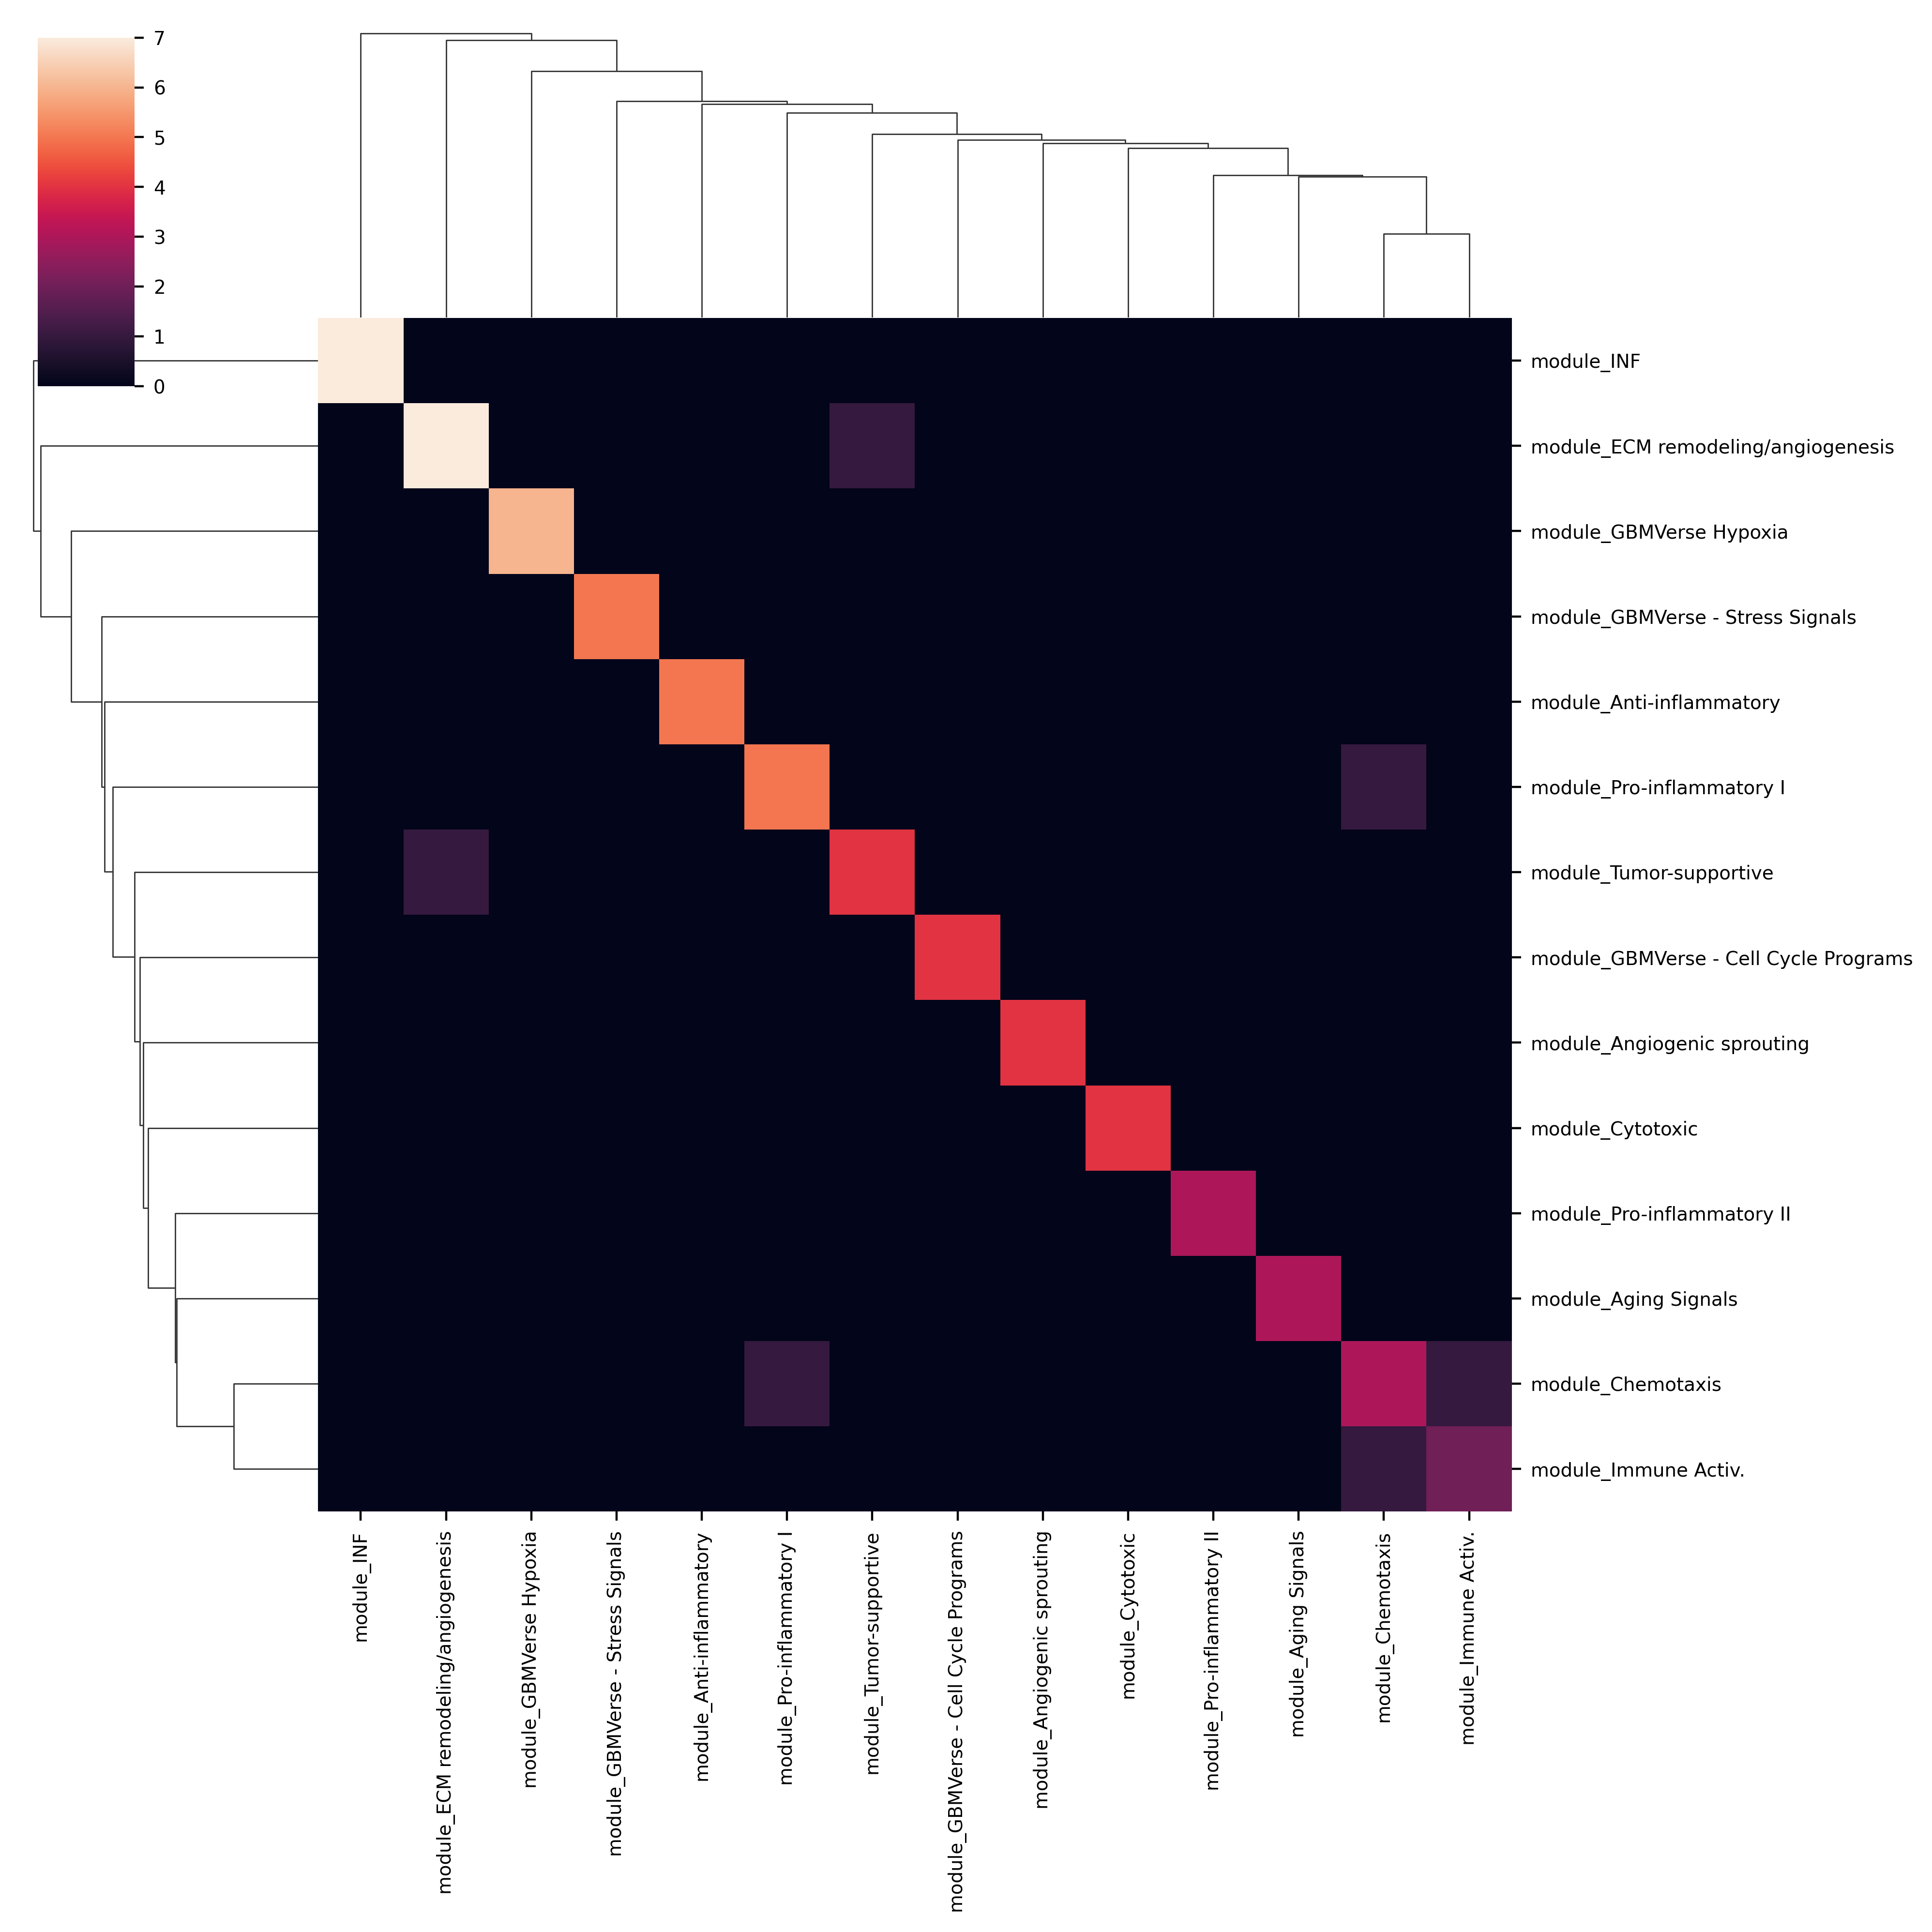

In [54]:
sns.clustermap(module_similarity.astype(int))

We can store the results of applying the signatures in an adata object

In [55]:
adata_regional.write(general_path+'/ISS_global_analysis/all_samples_regional.h5ad') #modify if possible

# We next apply the signatures defined as modules from the GBmap data (presented in the main figures)

In [7]:
adata_regional=sc.read(general_path+'/ISS_global_analysis/all_samples_regional.h5ad') #modify if possible
module=pd.read_csv(general_path+r"/module_list_GBM.csv",sep=';')

In [34]:
modules_gbmap=pd.read_excel(general_path+'/Supplemental tables.xlsx',sheet_name='S3',header=0).iloc[:,1:]

In [35]:
for c in modules_gbmap.columns:
    if 'Unnamed' in c:
        modules_gbmap.loc[0,c]=str(modules_gbmap.loc[0,c])+appendix
    else:
        appendix='_'+c
        modules_gbmap.loc[0,c]=str(modules_gbmap.loc[0,c])+appendix

In [36]:
modules_gbmap.columns=modules_gbmap.iloc[0,:]

In [50]:
module_names=[]
for mod in modules_gbmap.columns:
    try:
        print(mod)
        sel=list(modules_gbmap.loc[:,mod])
        sc.tl.score_genes(adata_regional,adata_regional.var.index[adata_regional.var.index.isin(sel)],score_name='module_'+mod)
        module_names.append('module_'+mod)
    except:
        print('not possible')

1_Neoplastic cells
2_Neoplastic cells
3_Neoplastic cells
4_Neoplastic cells
5_Neoplastic cells
6_Neoplastic cells
7_Neoplastic cells
8_Neoplastic cells
9_Neoplastic cells
10_Neoplastic cells
11_Neoplastic cells
12_Neoplastic cells
13_Neoplastic cells
14_Neoplastic cells
1_Tumor-associated macrophages
2_Tumor-associated macrophages
3_Tumor-associated macrophages
4_Tumor-associated macrophages
5_Tumor-associated macrophages
6_Tumor-associated macrophages
7_Tumor-associated macrophages
8_Tumor-associated macrophages
9_Tumor-associated macrophages
10_Tumor-associated macrophages
11_Tumor-associated macrophages
12_Tumor-associated macrophages
13_Tumor-associated macrophages
14_Tumor-associated macrophages
1_Tumor infiltrative lymphocytes
2_Tumor infiltrative lymphocytes
3_Tumor infiltrative lymphocytes
4_Tumor infiltrative lymphocytes
5_Tumor infiltrative lymphocytes
6_Tumor infiltrative lymphocytes
not possible
7_Tumor infiltrative lymphocytes
8_Tumor infiltrative lymphocytes
9_Tumor infil

In [52]:
modules=adata_regional.obs.loc[:,module_names]
express=modules
corr=pd.DataFrame(index=express.columns,columns=express.columns)
for i in tqdm(corr.index):
    #print(i)
    for c in corr.columns:
        corr.loc[i,c]=np.corrcoef(express.loc[:,i],express.loc[:,c])[0,1]

100%|███████████████████████████████████████████████████████████████████████████████████| 48/48 [00:45<00:00,  1.05it/s]


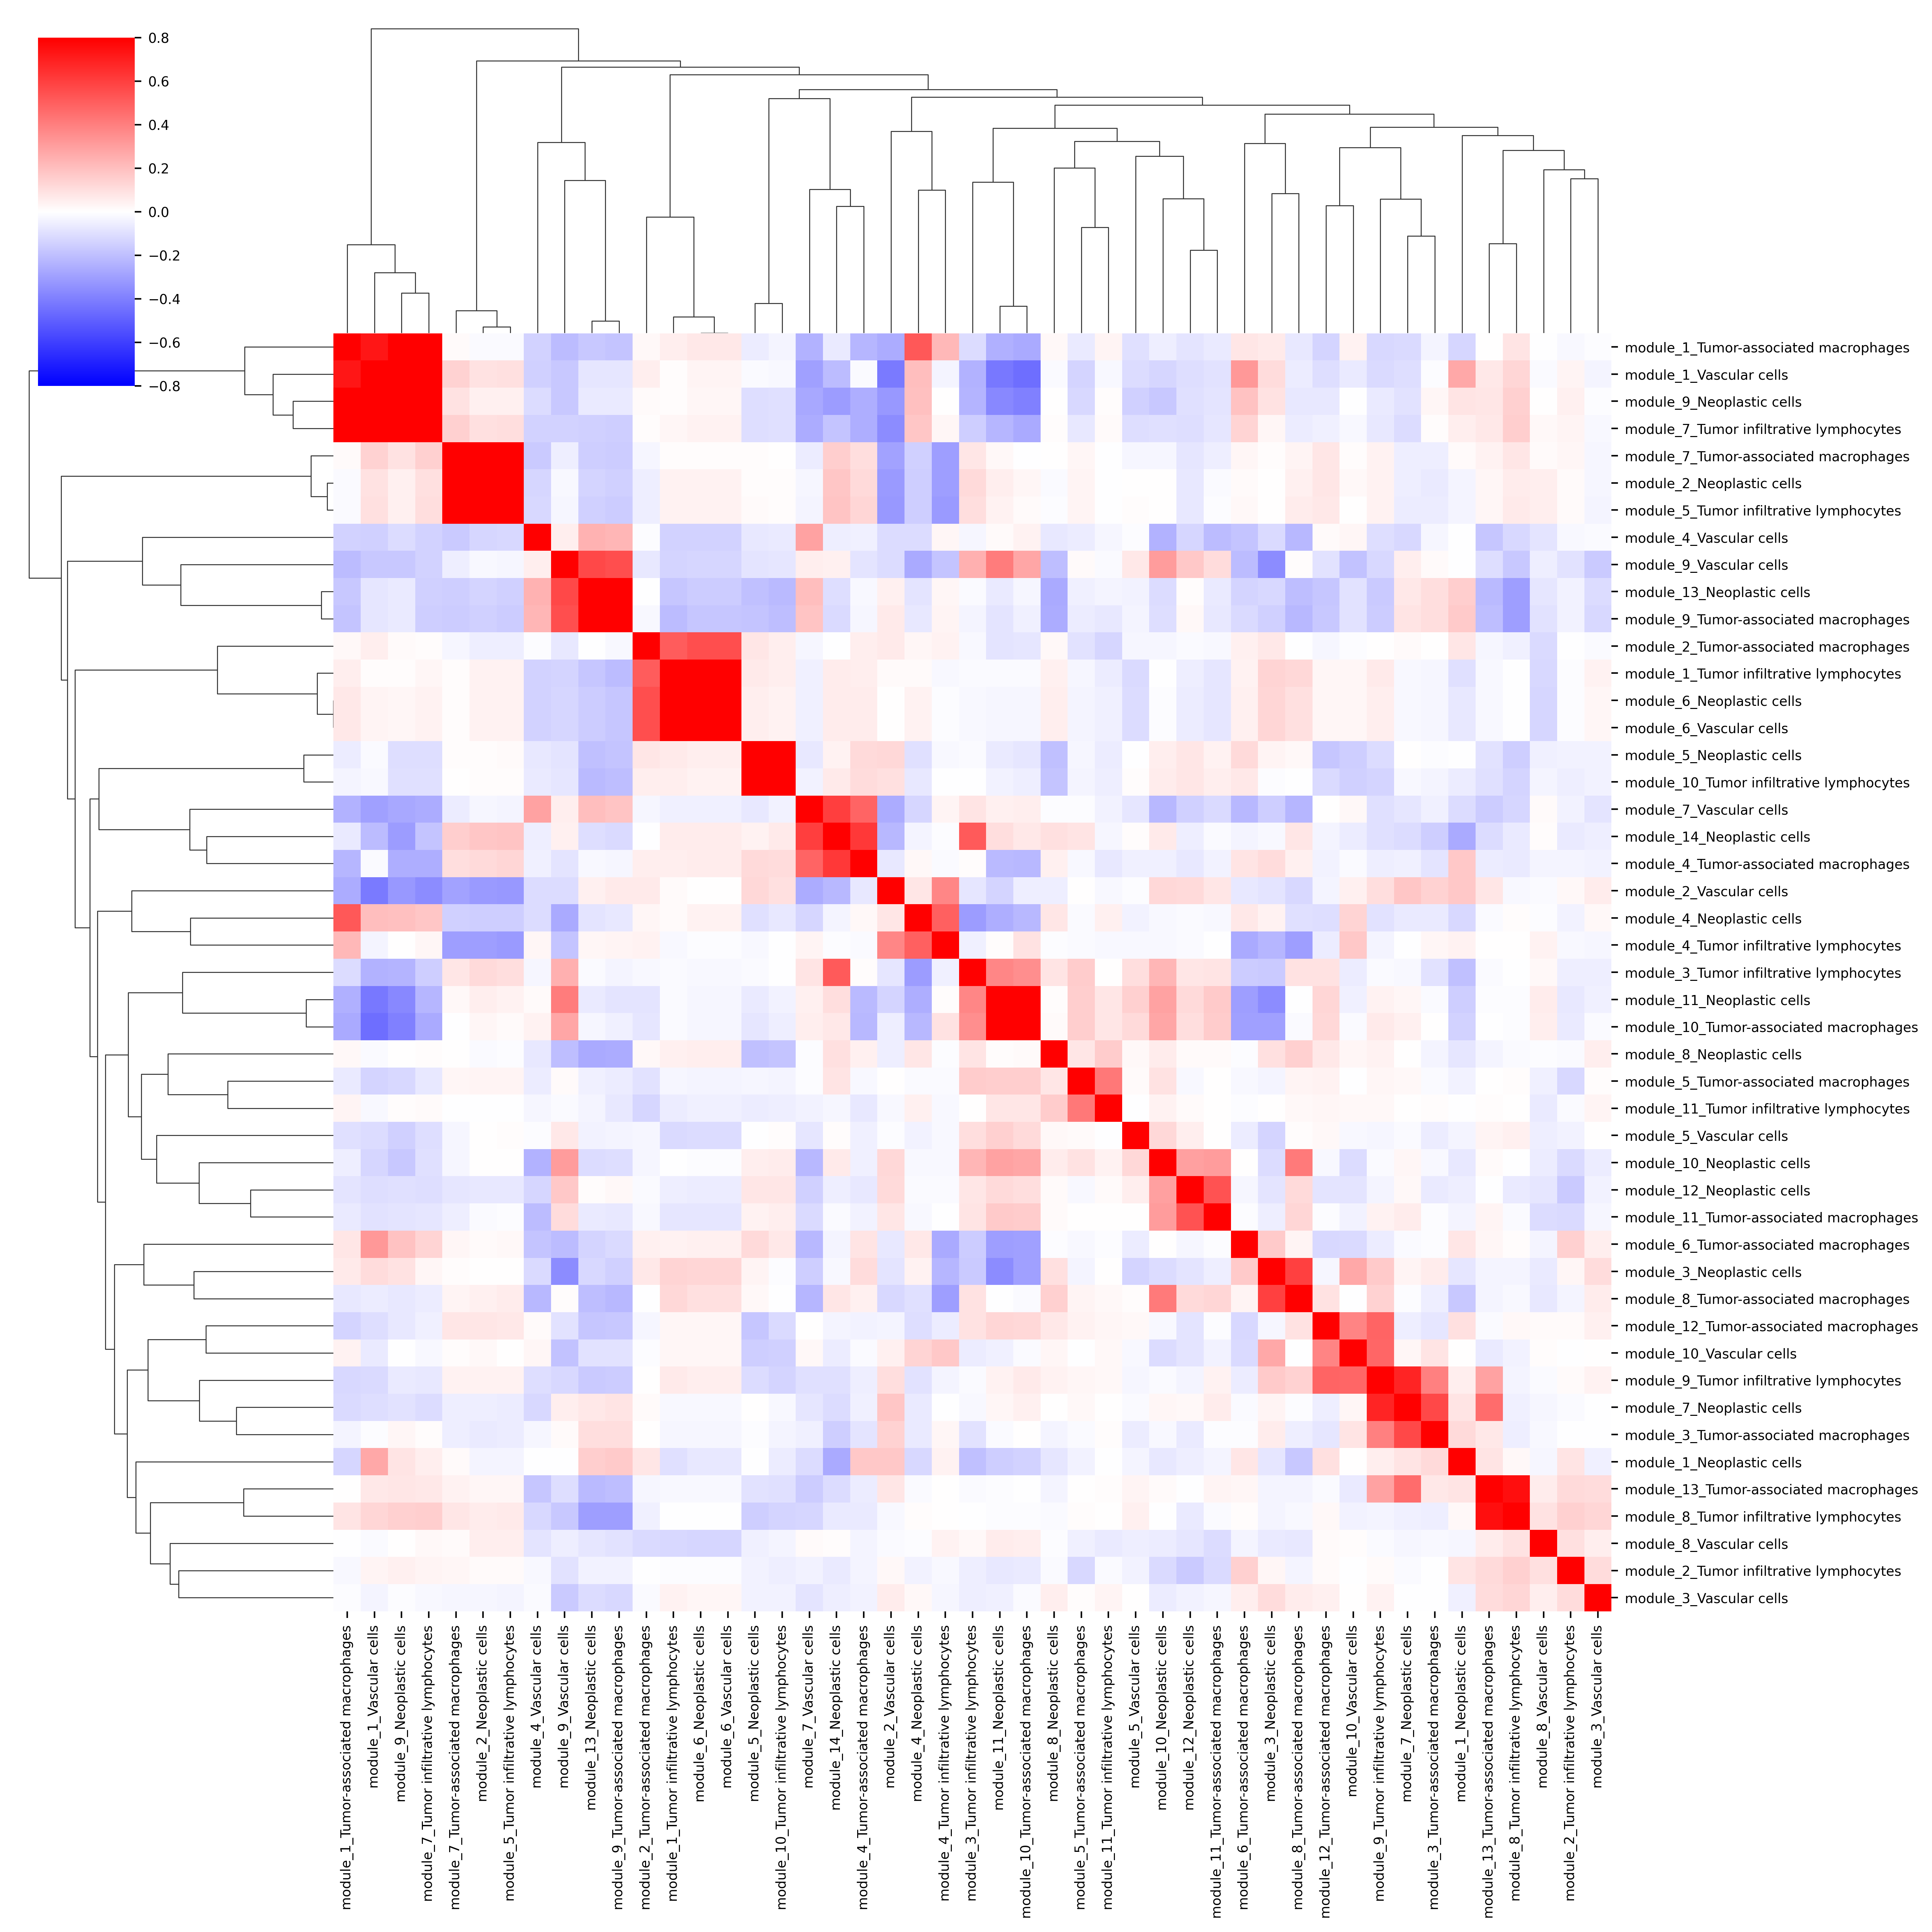

In [55]:
for i in corr.index:
    corr.loc[i,i]=0
sel=corr.index[np.max(abs(corr))>0.1]
corr2=corr.loc[sel,sel]
for i in corr2.index:
    corr2.loc[i,i]=1
    
import matplotlib
sc.set_figure_params(scanpy=True, dpi=200, dpi_save=200, frameon=False, vector_friendly=True, fontsize=7, figsize=(8,8), color_map=None, format='pdf', facecolor=None, transparent=False, ipython_format='png2x')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.clustermap(corr2.astype(float),vmax=0.8,figsize=(14,14),vmin=-0.8,cmap='bwr')
plt.savefig(general_path+'/ISS_global_analysis/modules/correlation_between_modules_all_samples_GBMAP_modules.pdf')

In [54]:
adata_regional.write(general_path+'/ISS_global_analysis/all_samples_regional_GBMAP_modules.h5ad') #modify if possible

### We take a look at signatures by sample


on a bulk level, we can just plot them like this, doing the mean

In [56]:
regional_expi=adata_regional.obs.groupby('sample').mean().loc[:,module_names].transpose()

Text(0.5, 1.0, 'Signatures of each sample')

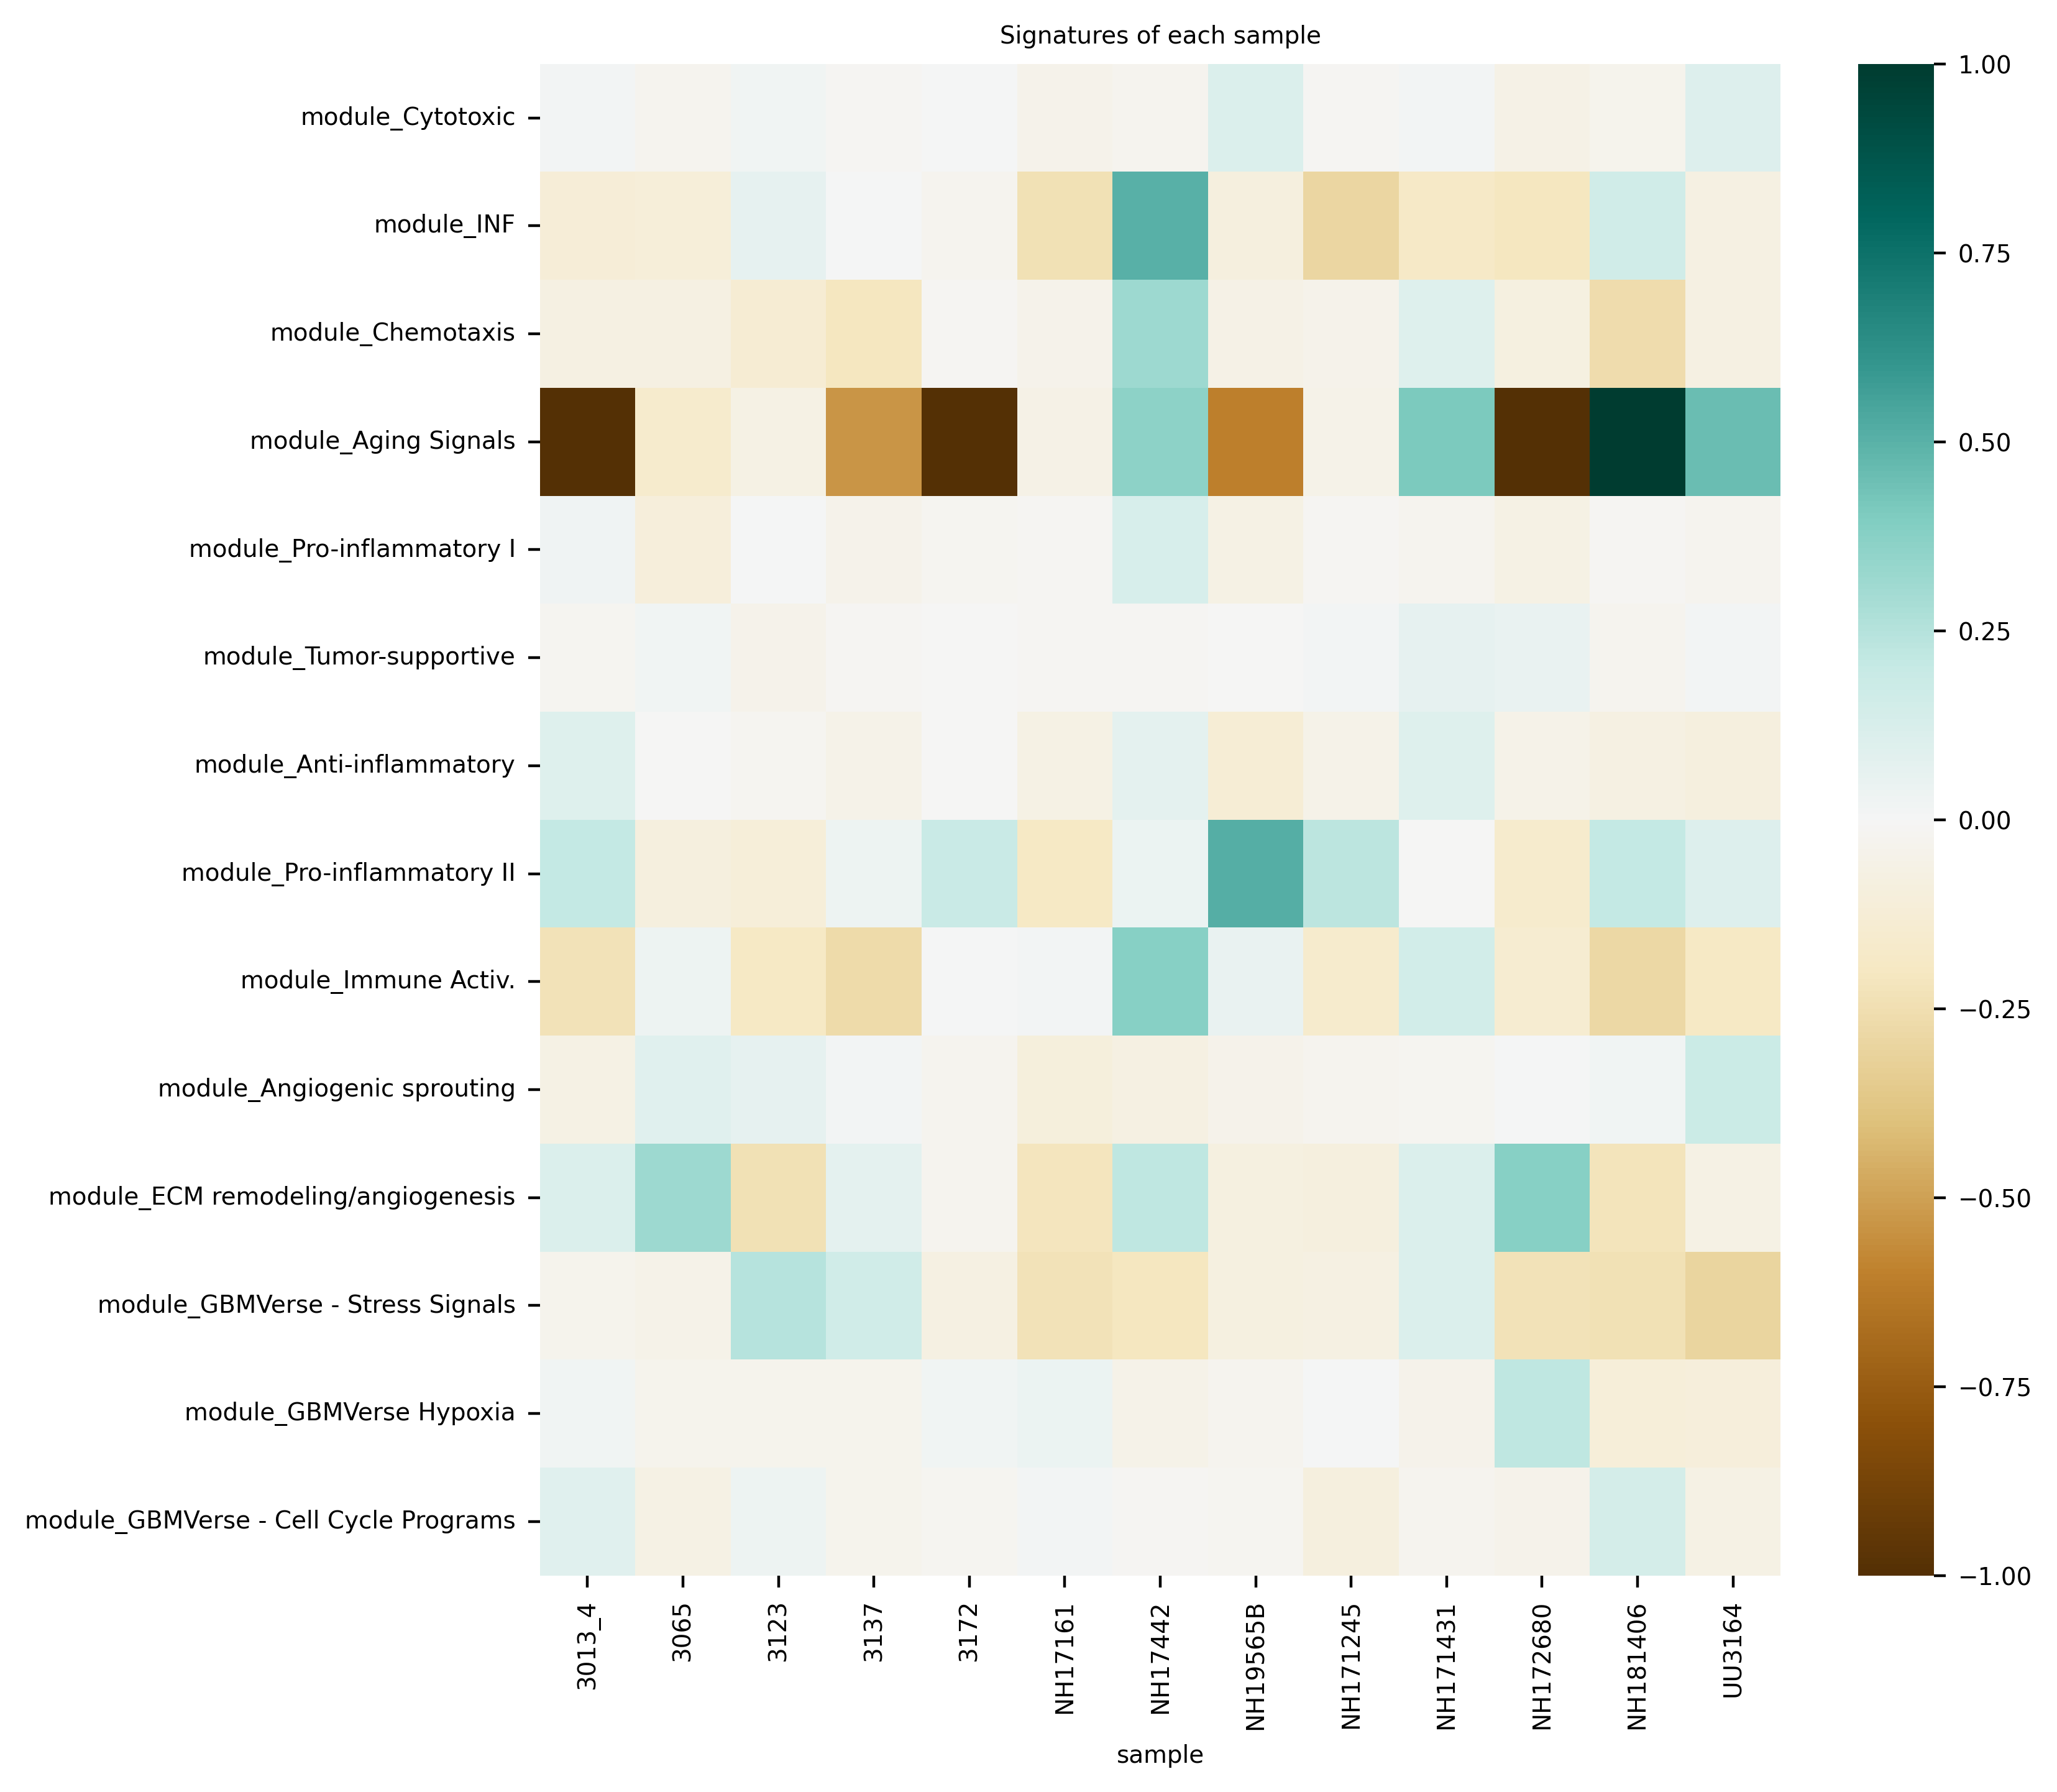

In [58]:
sns.heatmap(regional_expi,cmap='BrBG',vmin=-1,vmax=1)
plt.title('Signatures of each sample')

In [59]:
datamod=adata_regional.obs.loc[:,module_names]
datamod['sample']=adata_regional.obs.loc[:,'sample']

In [ ]:
for modi in module_names:
    sns.catplot(data=datamod,x='sample',y=modi,size=3,s=0.5,alpha=0.5,figsize=(15,7)) #kind is modifiable
    plt.title(modi)

# Applying Ivy-gap signatures

In [128]:
adata_regional=sc.read(general_path+'/ISS_global_analysis/all_samples_regional.h5ad') #modify if possible

In [130]:
general_path='/media/sergio/GBX/GBmap samples'
global_path=general_path+'ISS_samples/'
adataneigh=sc.read(general_path+'/ISS_global_analysis/all_samples_niches_v3_TENTATIVE_FOR_PUBLICATION.h5ad') # should be with colors

In [131]:
adataneigh.obs['UNI_ID']=adataneigh.obs.index.astype(str)+'_'+adataneigh.obs['sample'].astype(str)
adata_regional.obs['UNI_ID']=adata_regional.obs.index.astype(str)+'_'+adata_regional.obs['sample'].astype(str)

In [133]:
adata_regional=adata_regional[adata_regional.obs['UNI_ID'].isin(adataneigh.obs['UNI_ID'])]

In [134]:
signatures=pd.read_csv(general_path+r'/Ivy-GAP/mean_expression_ivy_gap_all.csv',index_col=0)

In [135]:
signaturesfilt=signatures.loc[:,signatures.columns.isin(adata_regional.var.index)]
signaturesfilt2=signaturesfilt.div(signaturesfilt.sum(axis=0),axis=1)
signaturesfilt=signaturesfilt.div(signaturesfilt.max(axis=0),axis=1)

In [138]:
adata_regional=adata_regional[:,adata_regional.var.index.isin(signatures.columns)]
adata_regional=adata_regional[:,signaturesfilt.columns]
sc.pp.subsample(adata_regional,1/70) #WE USE 15 because we defined neighborhood using 15 cells and we want to sort of include all info
dfr=adata_regional.to_df()
dfr=dfr.div(dfr.max(axis=0),axis=1)
from tqdm import tqdm
results=pd.DataFrame(index=adata_regional.obs.index,columns=signaturesfilt.index)
for cl in tqdm(adata_regional.obs.index):
    for cl2 in signaturesfilt.index:
        results.loc[cl,cl2]=cosinesim(dfr.loc[cl,:],signaturesfilt.loc[cl2,:])#[0,1]

100%|█████████████████████████████████████████████████████████████████████████████| 13496/13496 [23:34<00:00,  9.54it/s]


In [139]:
results=results.fillna(0)
for col in results.columns:
    adata_regional.obs[col]=results.loc[:,col]

In [ ]:
for md in results.columns:
    vvmax=np.percentile(adata_regional.obs.loc[:,md],99)
    vvmin=np.percentile(adata_regional.obs.loc[:,md],1)
    for s in adata_regional.obs['sample'].unique():
        adata_regional_sub=adata_regional[adata_regional.obs['sample']==s]
        sc.pl.spatial(adata_regional_sub,spot_size=300,color=md,vmin=vvmin,vmax=vvmax,cmap='coolwarm',show=False)

In [141]:
adata_regional.obs['maximum_signature']=results.idxmax(axis=1)
adata_regional.obs.loc[results.max(axis=1)<0.05,'maximum_signature']='Zero'

In [142]:
sample_data=pd.read_csv(r"/media/sergio/GBX/GBmap samples/Ivy-GAP/gene_expression_matrix_2014-11-25/columns-samples.csv")

In [143]:
sample_data['struc']=[n[0:10] for n in sample_data['structure_name']]

In [146]:
sample2domain=dict(zip(sample_data['structure_name'].astype(str),sample_data['struc']))

In [149]:
sample2domain['Zero']='Zero'

In [152]:
adata_regional.obs['collapsed_signature']=[sample2domain[str(v)] for v in adata_regional.obs['maximum_signature']]

In [154]:
df_reg=pd.crosstab(adata_regional.obs['collapsed_signature'],adata_regional.obs['sample']).transpose()

In [155]:
df_reg=df_reg.div(df_reg.sum(axis=1),axis=0)

<AxesSubplot:ylabel='sample'>

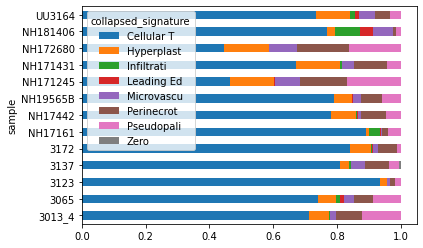

In [157]:
df_reg.plot(kind='barh',stacked='True')

## We try to relate ivygap signature with cell type ("className", a.k.a level 4 annotation)

In [158]:
celltype_probs_ivygap=pd.crosstab(adata_regional.obs['collapsed_signature'],adata_regional.obs['ClassName'])
celltype_probs_ivygap=celltype_probs_ivygap.div(celltype_probs_ivygap.sum(axis=1),axis=0)

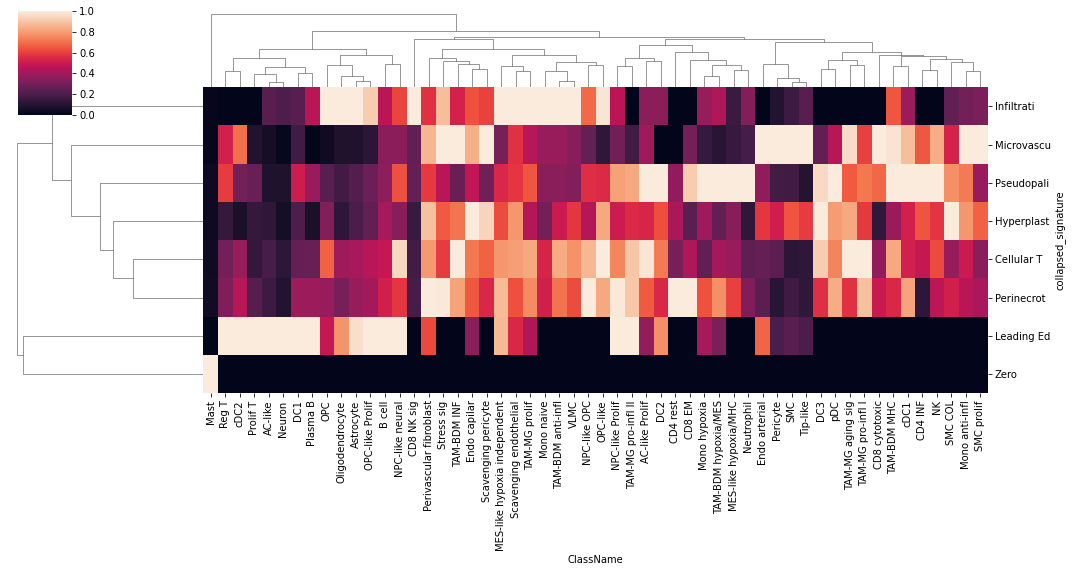

In [160]:
sns.clustermap(celltype_probs_ivygap,standard_scale=1,figsize=(15,8))

In [ ]:
for s in adata_regional.obs['sample'].unique():
    adata_regional_sub=adata_regional[adata_regional.obs['sample']==s]
    sc.pl.spatial(adata_regional_sub,spot_size=500,color='collapsed_signature',vmin=vvmin,vmax=vvmax,cmap='coolwarm',show=False)

In [389]:
adata_regional.write(general_path+'/ISS_global_analysis/all_samples_regional_with_ivygap_updated.h5ad')